In [104]:
import numpy as np
from numpy import pi
from pyquil.api import get_qc
from pyquil.api._devices import get_lattice
from pyquil import Program
from pyquil.gates import *

import matplotlib.pyplot as plt
%matplotlib inline



# Specify lattice name and show any stored specs

In [167]:
# lattice_name = 'Aspen-1-5Q-B'
lattice_name = '9q-square-noisy-qvm'
# lattice = get_lattice(lattice_name)
# stored_specs = lattice.get_specs()
# print(stored_specs)

# Create qc object, get qubits, and display the topology

# BE SURE TO SET as_qvm TRUE or FALSE as desired!!!

[0, 1, 2, 3, 4, 5, 6, 7, 8]


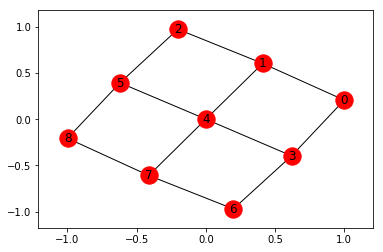

In [132]:
import networkx as nx

qc = get_qc(lattice_name, as_qvm=True, noisy=True)
qubits = qc.qubits()
print(qubits)
graph = qc.qubit_topology()
nx.draw_networkx(graph, with_labels=True)

# Active Reset Error

In [133]:
from forest_qcvv.readout import estimate_joint_reset_confusion
single_qubit_reset_cms = estimate_joint_reset_confusion(qc, qubits, num_trials = 10, joint_group_size = 1,
                                   use_active_reset = True)


Confusion matrix, Avg Fidelity

In [134]:
print(single_qubit_reset_cms)
print([np.round(np.sum(cm, axis=0)[0]/2, 3) for cm in single_qubit_reset_cms.values()])


{(0,): array([[1. , 0. ],
       [0.9, 0.1]]), (1,): array([[0.9, 0.1],
       [0.9, 0.1]]), (2,): array([[1. , 0. ],
       [0.9, 0.1]]), (3,): array([[1., 0.],
       [1., 0.]]), (4,): array([[1., 0.],
       [1., 0.]]), (5,): array([[1., 0.],
       [1., 0.]]), (6,): array([[1., 0.],
       [1., 0.]]), (7,): array([[1., 0.],
       [1., 0.]]), (8,): array([[1., 0.],
       [1., 0.]])}
[0.95, 0.9, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# Readout Errors

In [135]:
from forest_qcvv.readout import estimate_joint_confusion_in_set, marginalize_confusion_matrix
single_qubit_cms = estimate_joint_confusion_in_set(qc, qubits, num_shots=5000, joint_group_size=1,
                                    use_param_program=True, use_active_reset=False)


Confusion matrix, Avg Fidelity, Asymmetry

In [30]:
print(single_qubit_cms)
print([np.round(np.trace(cm)/2, 3) for cm in single_qubit_cms.values()])
from forest_qcvv.utils import sigma_z
print([np.round(np.trace(sigma_z @ cm)/2, 3) for cm in single_qubit_cms.values()])

{(0,): array([[0.9766, 0.0234],
       [0.0926, 0.9074]]), (1,): array([[0.9732, 0.0268],
       [0.0982, 0.9018]]), (2,): array([[0.9744, 0.0256],
       [0.0942, 0.9058]]), (3,): array([[0.9712, 0.0288],
       [0.0886, 0.9114]]), (4,): array([[0.9772, 0.0228],
       [0.0962, 0.9038]]), (5,): array([[0.972, 0.028],
       [0.098, 0.902]]), (6,): array([[0.9698, 0.0302],
       [0.0918, 0.9082]]), (7,): array([[0.9728, 0.0272],
       [0.0926, 0.9074]]), (8,): array([[0.968 , 0.032 ],
       [0.0906, 0.9094]])}
[0.942, 0.937, 0.94, 0.941, 0.94, 0.937, 0.939, 0.94, 0.939]
[0.035, 0.036, 0.034, 0.03, 0.037, 0.035, 0.031, 0.033, 0.029]


Simultaneous Confusion Matrix (pairwise; can try len(qubits) but may be too slow)

In [32]:
pairwise_cms = estimate_joint_confusion_in_set(qc, qubits, num_shots=1000, joint_group_size=2,
                                    use_param_program=True, use_active_reset=False)

 Look for Significant Correlated Error

In [48]:
marginal_absolute_tolerance = .02 # determines acceptable level of correlation

for qubit_pair, pair_cm in pairwise_cms.items():
    marginal_one_qs = [(qubit, marginalize_confusion_matrix(pair_cm, qubit_pair, [qubit])) for qubit in qubit_pair]
    for qubit, marginal_cm in marginal_one_qs:
        if not np.allclose(single_qubit_cms[(qubit,)], marginal_cm, atol=absolute_tolerance):
            print("Q" + str(qubit) + " readout is different when measuring pair", qubit_pair)
            
joint_absolute_tolerance = .03
for qubit_pair, pair_cm in pairwise_cms.items():
    joint_single_q_cm = np.kron(single_qubit_cms[(qubit_pair[0],)], single_qubit_cms[(qubit_pair[1],)])
    if not np.allclose(joint_single_q_cm, pair_cm, atol=joint_absolute_tolerance):
        print(qubit_pair, "exhibits correlated readout error")


Q3 readout is different when measuring pair (3, 6)
Q5 readout is different when measuring pair (5, 6)
(3, 6) exhibits correlated readout error
(5, 6) exhibits correlated readout error


# T1/T2

Neither estimation of T1 or T2 will work on a QVM

## T1

In [75]:
from pyrethrum.qubit_spectroscopy import run_t1, exponential_decay_curve, fit_to_exponential_decay_curve
MICROSECOND = 1e-6
def get_T1s_from_data_fit(df, show_plot: bool = False,
                                                  filename: str = None) -> np.ndarray:
    """
    Plot T1 experimental data and fitted exponential decay curve.

    :param df: Experimental results to plot and fit exponential decay curve to.
    :return: list of estimated t1s in microseconds
    """
    t1s = np.array([])
    for q in df['qubit'].unique():
        df2 = df[df['qubit'] == q].sort_values('time')
        x_data = df2['time']
        y_data = df2['avg']

        plt.plot(x_data, y_data, 'o-', label=f"QC{q} T1 data")

        try:
            fit_params, fit_params_errs = fit_to_exponential_decay_curve(x_data, y_data)
        except RuntimeError:
            print(f"Could not fit to experimental data for QC{q}")
            t1s = np.append(t1s,[np.nan])
        else:
            plt.plot(x_data, exponential_decay_curve(x_data, *fit_params),
                     label=f"QC{q} fit: T1={fit_params[1] / MICROSECOND:.2f}us")
            t1s = np.append(t1s,[fit_params[1]/MICROSECOND])

    plt.xlabel("Time [s]")
    plt.ylabel("Excited state visibility")
    plt.title("T1 decay")

    plt.legend(loc='best')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return t1s
    
t1_df = run_t1(qc, qubits, stop_time = 60*MICROSECOND, n_shots = 1000, num_points = 15)
t1s = get_T1s_from_data_fit(t1_df)
print("T1s in microseconds:", np.round(t1s,1))

Could not fit to experimental data for QC3
Could not fit to experimental data for QC5
Could not fit to experimental data for QC6
T1s in microseconds: [29228.8  6780.6  8635.5     nan  5848.9     nan     nan 14918.3  7271.4]


# $T_2^*$ Ramsey

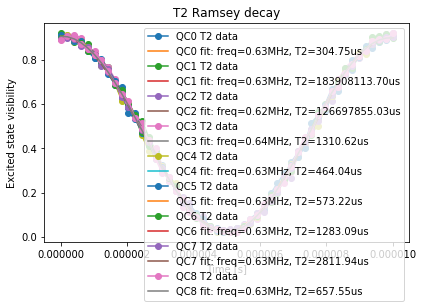

T2s in microseconds: [3.04700000e+02 1.83908114e+08 1.26697855e+08 1.31060000e+03
 4.64000000e+02 5.73200000e+02 1.28310000e+03 2.81190000e+03
 6.57600000e+02]
Detunings in MHz: [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]


In [78]:
from pyrethrum.qubit_spectroscopy import run_t2, exponentially_decaying_sinusoidal_curve, fit_to_exponentially_decaying_sinusoidal_curve
MHZ = 1e6
MICROSECOND = 1e-6
from typing import List
def get_T2s_from_data_fit(df, show_plot: bool = False, filename: str = None,
                                                detuning: float = 5e6) -> np.ndarray:
    """
    Plot T2 experimental data and fitted exponential decay curve.

    :param df: Experimental results to plot and fit exponential decay curve to.
    :param detuning: Detuning frequency used in experiment creation.
    :return: list of estimated t2s
    """
    t2s=np.array([])
    detunings=np.array([])
    for q in df['qubit'].unique():
        df2 = df[df['qubit'] == q].sort_values('time')
        x_data = df2['time']
        y_data = df2['avg']

        plt.plot(x_data, y_data, 'o-', label=f"QC{q} T2 data")

        try:
            fit_params, fit_params_errs = fit_to_exponentially_decaying_sinusoidal_curve(x_data,
                                                                                         y_data,
                                                                                         detuning)
        except RuntimeError:
            print(f"Could not fit to experimental data for QC {q}")
            t2s = np.append(t2s,[np.nan])
            detunings = np.append(detunings, [np.nan])
        else:
            plt.plot(x_data, exponentially_decaying_sinusoidal_curve(x_data, *fit_params),
                     label=f"QC{q} fit: freq={fit_params[2] / MHZ:.2f}MHz, "
                           f"T2={fit_params[1] / MICROSECOND:.2f}us")
            t2s = np.append(t2s,[fit_params[1]/MICROSECOND])
            detunings = np.append(detunings, fit_params[2] / MHZ)
            
    plt.xlabel("Time [s]")
    plt.ylabel("Excited state visibility")
    plt.title("T2 Ramsey decay")

    plt.legend(loc='best')
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)

    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return t2s, detunings
    
t2_df,detuning_used = run_t2(qc, qubits, stop_time = 10*MICROSECOND, n_shots = 1000, num_points = 50)
t2s, detunings = get_T2s_from_data_fit(t2_df, show_plot=True, detuning=detuning_used)
print("T2s in microseconds:", np.round(t2s,1))
print("Detunings in MHz:", np.round(detunings,1))

# Single Qubit Gate Fidelity

In [84]:
from pyquil.api import get_benchmarker
from forest_qcvv.rb import (add_sequences_to_dataframe,
                            add_survivals,
                            generate_simultaneous_rb_sequence,
                            rb_dataframe,
                            run_rb_measurement,
                            survivals_by_qubits,
                           fit_standard_rb)
from forest_qcvv.analysis.fitting import make_figure
bm = get_benchmarker()

Estimate 1q fidelity separately 

[0.9999693890325088, 0.030105500193838543, 1.0001254067870453, 1.0464029221157476, 0.9999598064815857, 0.8196909568658465, 0.999703279631058, 0.6677360303020466, 0.9999642570920682]


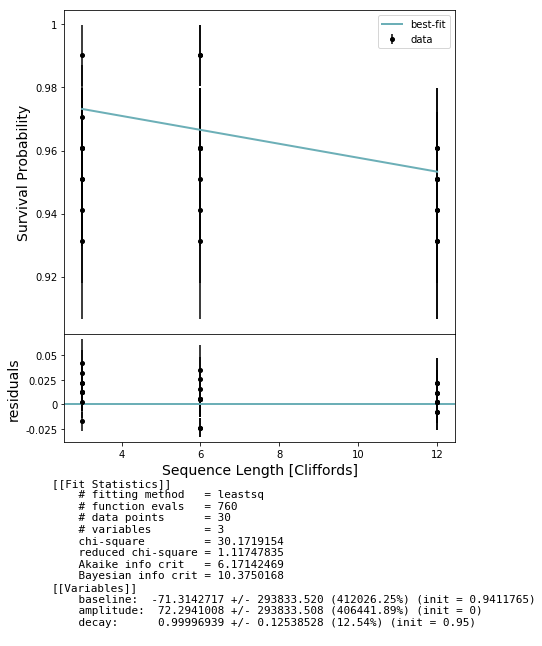

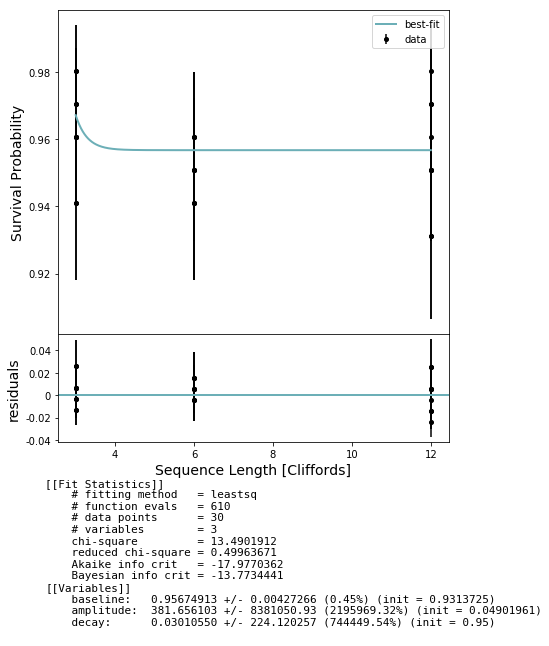

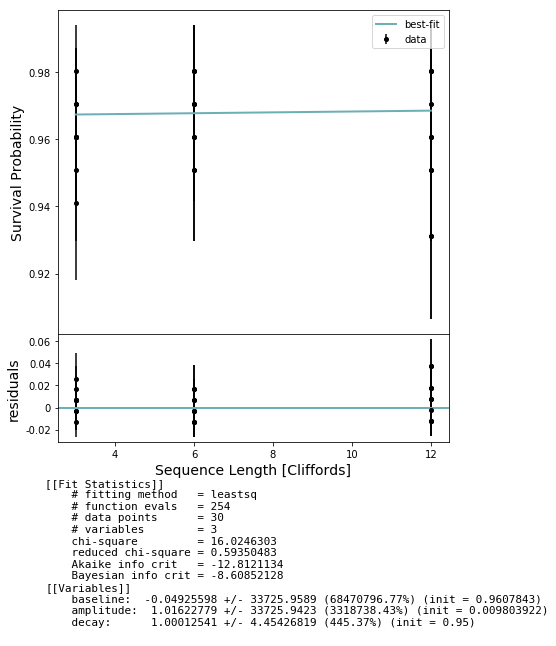

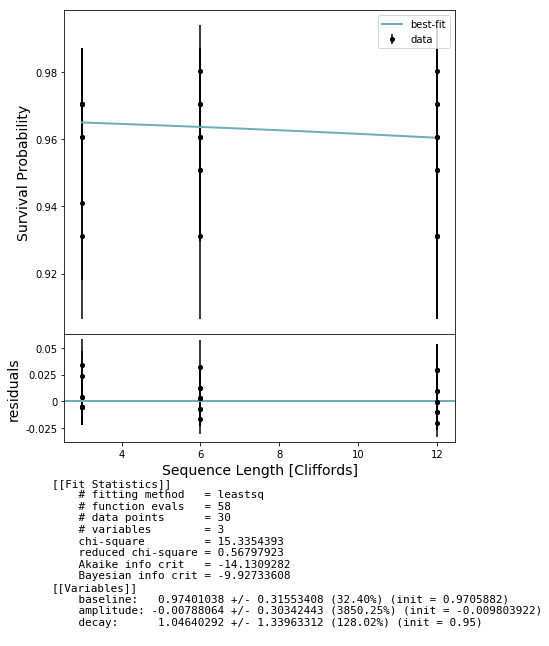

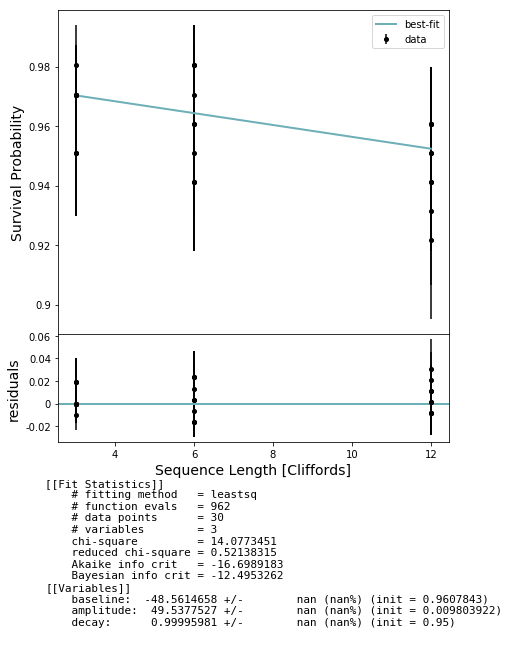

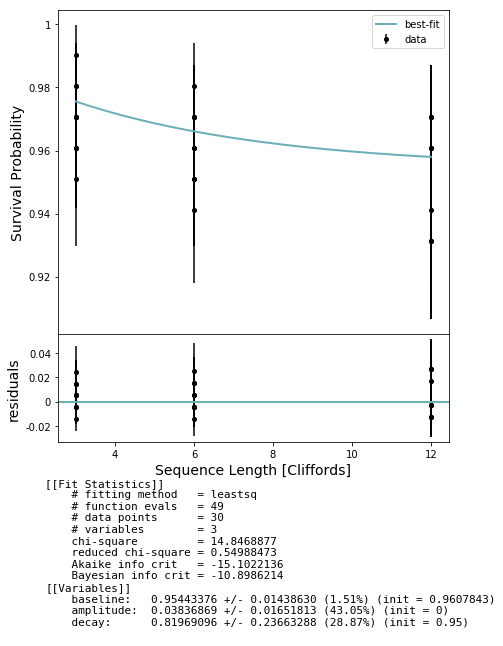

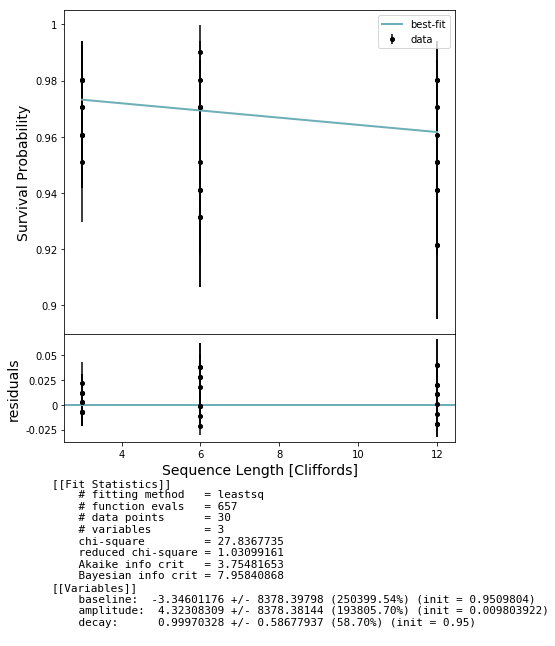

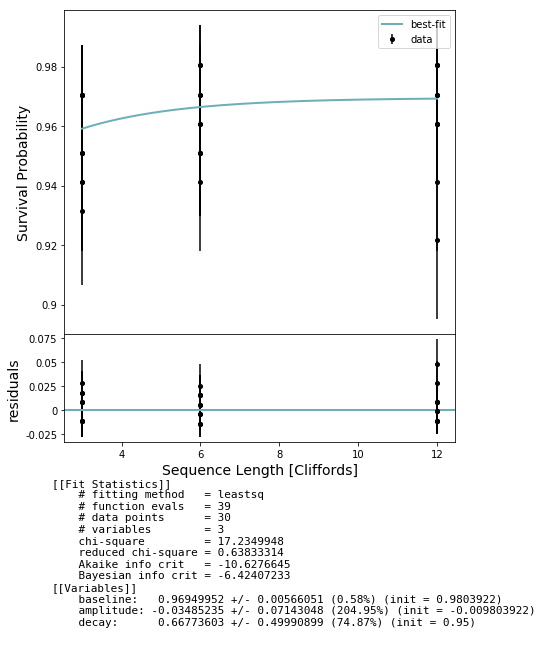

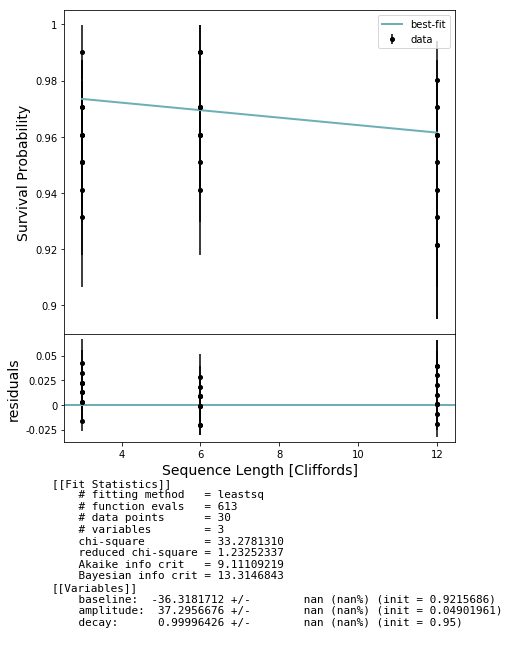

In [85]:
separate_1q_dfs = []
depths_1q, survivals_1q, survival_errs_1q = {}, {}, {}
separate_1q_rb_decays = []

for qubit in qubits:
    df = rb_dataframe(rb_type="std-1q",
                  subgraph=[(qubit,)],
                  depths=3 * 2 ** np.arange(4, dtype=np.uint8),
                  num_sequences=50)
    df = add_sequences_to_dataframe(df, bm)
    df = run_rb_measurement(df, qc, num_trials=500)
    df = add_survivals(df)
    separate_1q_dfs.append(df)
    
    depths_1q[qubit], survivals_1q[qubit], survival_errs_1q[qubit] = survivals_by_qubits(df, (qubit,)) 
    fit = fit_standard_rb(depths_1q[qubit], survivals_1q[qubit], weights=1/survival_errs_1q[qubit])
    separate_1q_rb_decays.append(fit.params['decay'].value)
    
    fig, axs = make_figure(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")
    
print(separate_1q_rb_decays)

Estimate simultaneous 1q fidelity

[0.9999737926287726, 0.9999876567318821, 0.999983797381953, 0.9977010882416756, 0.9063465476774805, 0.9999787611538756, 0.9999835628509017, 0.5470888960482844, 1.0000231314891164]


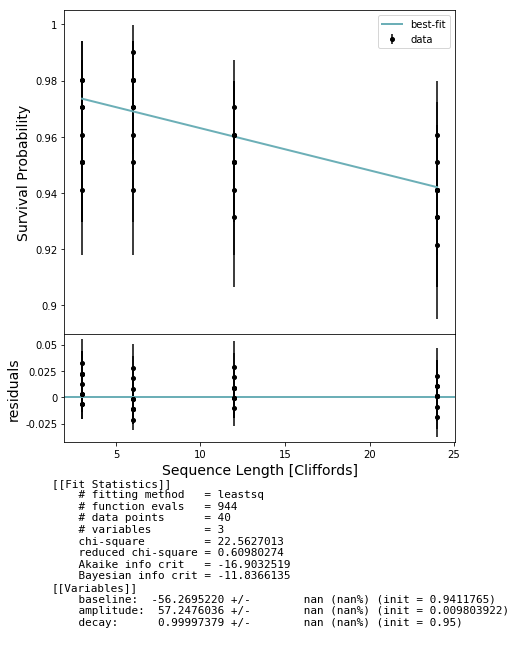

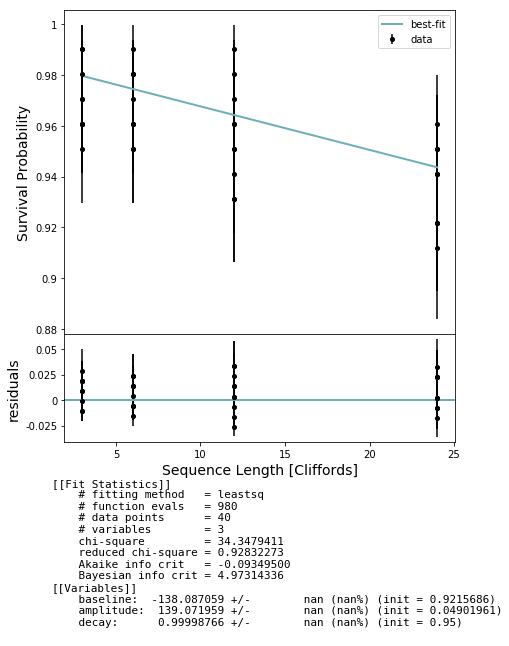

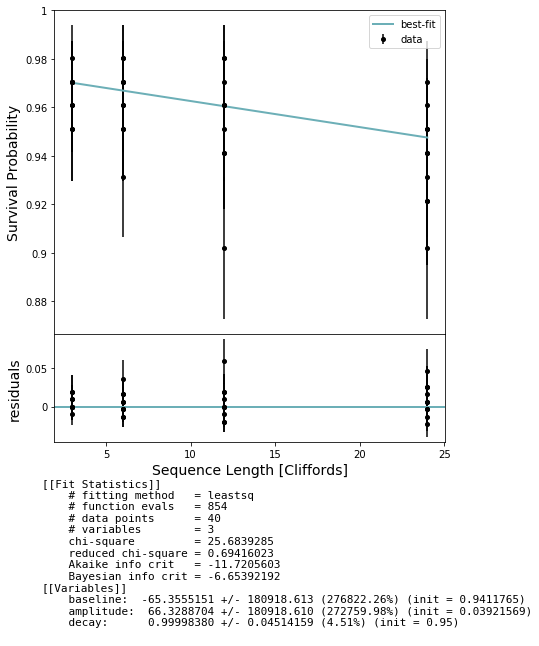

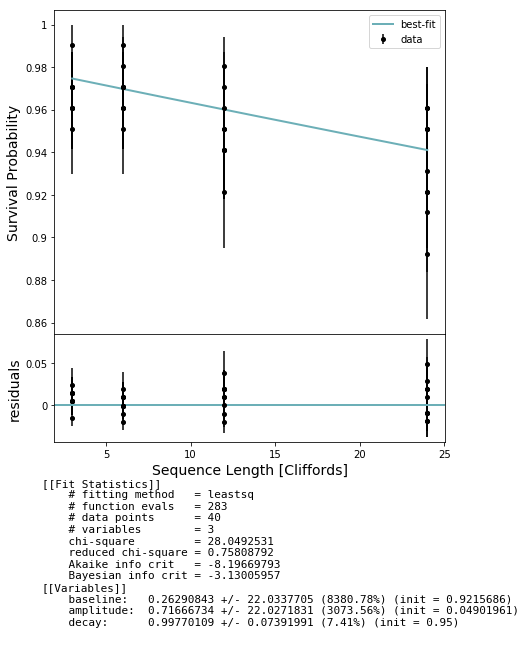

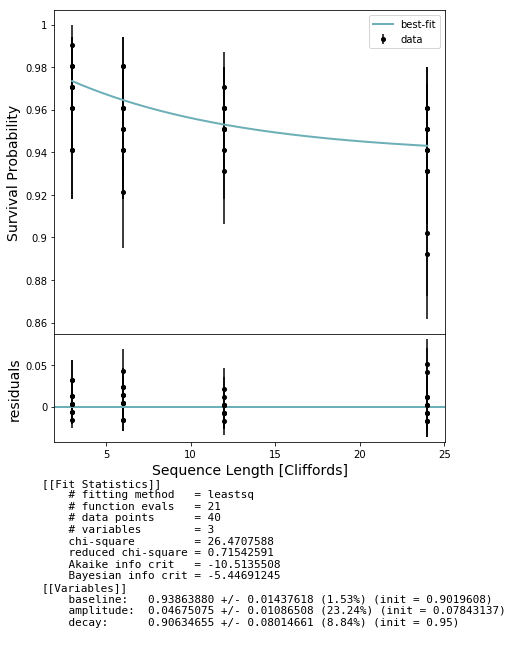

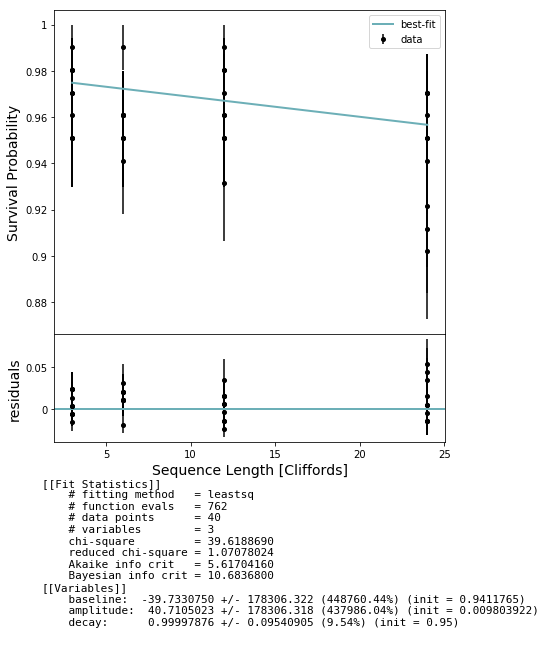

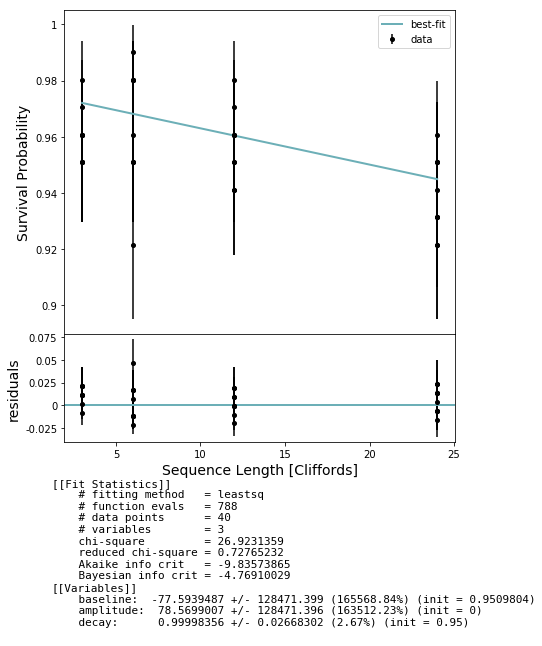

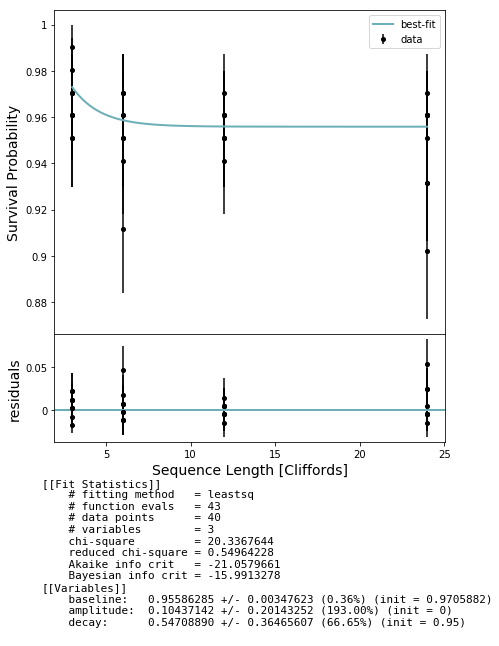

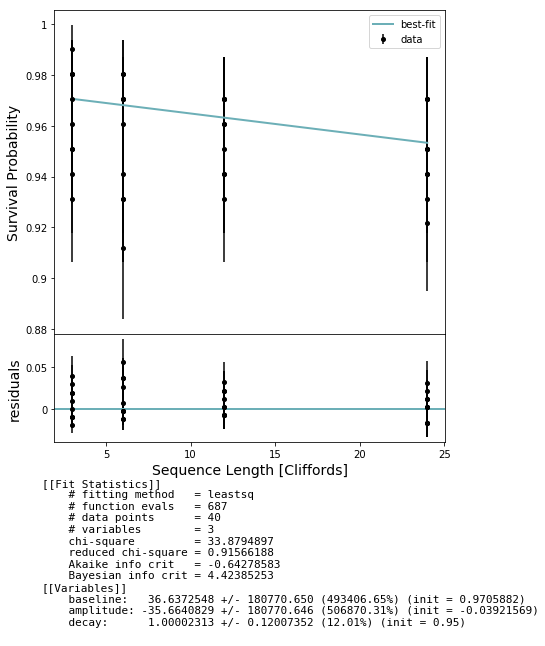

In [87]:
separate_1q_dfs = []
depths_1q, survivals_1q, survival_errs_1q = {}, {}, {}
simult_1q_rb_decays = []

simult_1q_df = rb_dataframe(rb_type="sim-1q",
                  subgraph=[(qubit,) for qubit in qubits],
                  depths=3 * 2 ** np.arange(4, dtype=np.uint8),
                  num_sequences=50)
simult_1q_df = add_sequences_to_dataframe(simult_1q_df, bm)
simult_1q_df = run_rb_measurement(simult_1q_df, qc, num_trials=500)
simult_1q_df = add_survivals(simult_1q_df)

for qubit in qubits:
    depths, survivals, survival_errs = {}, {}, {}
    depths[qubit], survivals[qubit], survival_errs[qubit] = survivals_by_qubits(simult_1q_df, (qubit,))
    fit = fit_standard_rb(depths[qubit], survivals[qubit], weights=1/survival_errs[qubit])
    simult_1q_rb_decays.append(fit.params['decay'].value)
    
    fig, axs = make_figure(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")
    
print(simult_1q_rb_decays)

In [90]:
for qubit, (simult, sep) in zip(qubits, zip(simult_1q_rb_decays, separate_1q_rb_decays)):
    if not np.allclose(simult, sep, atol = .05):
        print("qubit " + str(qubit) + " may be suffering from significant 1q cross-talk.")

qubit 1 may be suffering from significant 1q cross-talk.
qubit 4 may be suffering from significant 1q cross-talk.
qubit 5 may be suffering from significant 1q cross-talk.
qubit 7 may be suffering from significant 1q cross-talk.


# CZ Fidelity (SLOW on qvm. Set variance as desired)

In [145]:
from forest_qcvv.dfe import generate_process_dfe_experiment, acquire_dfe_data, direct_fidelity_estimate

desired_variance = .1

if not bm:
    bm = get_benchmarker()

cz_fidelities = []
for edge in graph.edges():
    p = Program(CZ(edge[0], edge[1]))
    process_exp = generate_process_dfe_experiment(p, bm)
    data,cal = acquire_dfe_data(process_exp, qc, desired_variance)
    fidelity_est = direct_fidelity_estimate(data,cal,'process')
    print(edge, " : ", fidelity_est.fid_point_est, "+/-", np.sqrt(fidelity_est.fid_var_est))
    cz_fidelities.append((edge, fidelity_est))


(0, 3)  :  (1.024977201365718+0j) +/- (0.022232254993345444+0j)
(0, 1)  :  (1.020152434676558+0j) +/- (0.02056318388706786+0j)
(1, 4)  :  (1.0059512007748832+0j) +/- (0.020543863355134244+0j)
(1, 2)  :  (1.019108658249357+0j) +/- (0.020965994142089495+0j)
(2, 5)  :  (0.9922272948263337+0j) +/- (0.021132187865834772+0j)
(3, 6)  :  (0.9765413232498915+0j) +/- (0.02028570227956899+0j)
(3, 4)  :  (1.0073916361416362+0j) +/- (0.020195572943178763+0j)
(4, 7)  :  (1.0080434570152128+0j) +/- (0.02136322637508017+0j)
(4, 5)  :  (1.0262082897756184+0j) +/- (0.02210462572645652+0j)
(5, 8)  :  (0.9833947939761893+0j) +/- (0.020073657591138154+0j)
(6, 7)  :  (0.9869438938553161+0j) +/- (0.02113791656621539+0j)
(7, 8)  :  (0.9921849211335001+0j) +/- (0.0218632579866+0j)


# CZ Cross Talk

In [158]:
from forest_qcvv.rpe import (generate_rpe_experiments, 
                             acquire_rpe_data, 
                             find_expectation_values, 
                             robust_phase_estimate)
CZ_qubits = (0,1)
measure_qubit = 3

num_depths = 6
multiplicative_factor = 100

rpe_experiments = generate_rpe_experiments(Program(CZ(*CZ_qubits)), 
                                       num_depths, 
                                       measurement_qubit = measure_qubit)
rpe_experiments = acquire_rpe_data(rpe_experiments, qc, multiplicative_factor)
xs, ys, x_stds, y_stds = find_expectation_values(rpe_experiments)

rz_local_phase_on_qubit = robust_phase_estimate(xs, ys, x_stds, y_stds)
print(rz_local_phase_on_qubit)

/home/kylegulshen/forest-qcvv/forest_qcvv/rpe.py:170: UserWarning: If the rotation provided is not about the Z axis, remember to specify an axis of rotation in polar coordinates (theta, phi) radians
  warnings.warn("If the rotation provided is not about the Z axis, "


6.280690620126078


# All qubits RX calibration

In [165]:
angles = [-pi, -pi/2, pi/2, pi]

num_depths = 6 # max depth of 2^(num_depths - 1)
factor = 100 # Multiply the optimal number of shots by this factor for each experiment
add_error = None # Try to correct for this additivie error by increasing the number of shots in an optimal way

for qubit in qubits:
    print("Q" + str(qubit))
    for angle in angles:
        experiments_1q = generate_rpe_experiments(RX(angle, qubit), num_depths, axis=(pi/2,0))
        experiments_1q = acquire_rpe_data(experiments_1q, qc, multiplicative_factor = factor, additive_error = add_error)
        xs, ys, x_stds, y_stds = find_expectation_values(experiments_1q)
        estimated_angle = robust_phase_estimate(xs, ys, x_stds, y_stds)
        if angle < 0 and estimated_angle > 0:
            estimated_angle = estimated_angle - 2*pi
        if angle > 0 and estimated_angle < 0:
            estimated_angle = estimated_angle + 2*pi
        print("Est. Angle:  ", np.round(estimated_angle, 4))
        print("Ideal Angle: ", np.round(angle, 4))
        print()


Q0
Est. Angle:   -3.1499
Ideal Angle:  -3.1416

Est. Angle:   -1.5683
Ideal Angle:  -1.5708

Est. Angle:   1.5839
Ideal Angle:  1.5708

Est. Angle:   3.1374
Ideal Angle:  3.1416

Q1
Est. Angle:   -3.1352
Ideal Angle:  -3.1416

Est. Angle:   -1.5603
Ideal Angle:  -1.5708

Est. Angle:   1.5723
Ideal Angle:  1.5708

Est. Angle:   3.1472
Ideal Angle:  3.1416

Q2
Est. Angle:   -3.1416
Ideal Angle:  -3.1416

Est. Angle:   -1.5666
Ideal Angle:  -1.5708

Est. Angle:   1.5594
Ideal Angle:  1.5708

Est. Angle:   3.1483
Ideal Angle:  3.1416

Q3
Est. Angle:   -3.1416
Ideal Angle:  -3.1416

Est. Angle:   -1.5669
Ideal Angle:  -1.5708

Est. Angle:   1.5692
Ideal Angle:  1.5708

Est. Angle:   3.1416
Ideal Angle:  3.1416

Q4
Est. Angle:   -3.1466
Ideal Angle:  -3.1416

Est. Angle:   -1.5599
Ideal Angle:  -1.5708

Est. Angle:   1.5638
Ideal Angle:  1.5708

Est. Angle:   3.1446
Ideal Angle:  3.1416

Q5
Est. Angle:   -3.1386
Ideal Angle:  -3.1416

Est. Angle:   -1.5722
Ideal Angle:  -1.5708

Est. Angle: 